In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}
from copy import copy
from dataset import generate_synthetic_data2, calc_true_value2, generate_synthetic_data3, generate_synthetic_data4
from estimators import calc_avg, calc_ips, calc_mips, calc_new_ips, calc_new_mips,calc_new_dr,calc_new_offcem
from utils import eps_greedy_policy, aggregate_simulation_results, remove_outliers

In [18]:
## シミュレーション設定
num_runs = 50 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
num_clusters = 30 # 行動クラスタ数
num_data = 1000 # ログデータのサイズ
beta = -0.2 # データ収集方策のパラメータ
lambda1_ = 0.0 # クラスタ効果と残差効果の配合率
lambda0_ = 0.0
random_state = 12345
random1_ = check_random_state(random_state)
random0_ = check_random_state(random_state+22)
random_ = check_random_state(random_state+1)
num_actions_list = [250, 500, 1000, 2000] # 行動数, |A|

In [19]:
result_df_list = []
theta_g_1 = random1_.normal(size=(dim_context, num_clusters))
M_g_1 = random1_.normal(size=(dim_context, num_clusters))
b_g_1 = random1_.normal(size=(1, num_clusters))
theta_g_0 = random0_.normal(size=(dim_context, num_clusters))
M_g_0 = random0_.normal(size=(dim_context, num_clusters))
b_g_0 = random0_.normal(size=(1, num_clusters))

for num_actions in num_actions_list:
    ## 期待報酬関数を定義するためのパラメータを抽出
    phi_a = random_.choice(num_clusters, size=num_actions)
    
    theta_h_1 = random1_.normal(size=(dim_context, num_actions))
    M_h_1 = random1_.normal(size=(dim_context, num_actions))
    b_h_1 = random1_.normal(size=(1, num_actions))

    theta_h_0 = random0_.normal(size=(dim_context, num_actions))
    M_h_0 = random0_.normal(size=(dim_context, num_actions))
    b_h_0 = random0_.normal(size=(1, num_actions))

    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value2(
        dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters, phi_a=phi_a,
        theta_g_0=theta_g_0,M_g_0=M_g_0,b_g_0=b_g_0,theta_h_0=theta_h_0,
        M_h_0=M_h_0,b_h_0=b_h_0,theta_g_1=theta_g_1,M_g_1=M_g_1,
        b_g_1=b_g_1,theta_h_1=theta_h_1,M_h_1=M_h_1,
        b_h_1=b_h_1,lambda0_=lambda0_,lambda1_=lambda1_,beta=beta
    )

    estimated_policy_value_list = []
    
    for _ in tqdm(range(num_runs), desc=f"num_actions={num_actions}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data4(
            num_data=num_data, phi_a=phi_a,
            theta_g_0=theta_g_0,M_g_0=M_g_0,b_g_0=b_g_0,theta_h_0=theta_h_0,
            M_h_0=M_h_0,b_h_0=b_h_0,theta_g_1=theta_g_1,M_g_1=M_g_1,
            b_g_1=b_g_1,theta_h_1=theta_h_1,M_h_1=M_h_1,
            b_h_1=b_h_1,lambda0_=lambda0_,lambda1_=lambda1_,
            dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters,beta=beta, random_state = _
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["cate_x_a"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["Newips"] = calc_new_ips(offline_logged_data, pi)
        #estimated_policy_values["mips_takashi"] = calc_new_mips_takashi3(offline_logged_data, pi)
        estimated_policy_values["Newdr"] = calc_new_dr(offline_logged_data, pi,
            q0_hat = offline_logged_data["q_x_a_0"] + random_.normal(size=(num_data, num_actions)),
            q1_hat = offline_logged_data["q_x_a_1"] + random_.normal(size=(num_data, num_actions))
        )
        estimated_policy_values["Newmips"] = calc_new_mips(offline_logged_data, pi)
        #estimated_policy_values["mips (w_hat)"] = calc_mips(offline_logged_data, pi, is_estimate_w=True)
        q_1_hat = offline_logged_data["h_x_a_1"] + random_.normal(size=(num_data, num_actions))
        q_0_hat = offline_logged_data["h_x_a_0"] + random_.normal(size=(num_data, num_actions))
        estimated_policy_values["NewOffCEM"] = calc_new_offcem(offline_logged_data, pi, q_1_hat, q_0_hat)
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_actions", num_actions,
        )
    )
result_df_actions = pd.concat(result_df_list).reset_index(level=0)


num_actions=2000...: 100%|██████████| 50/50 [06:31<00:00,  7.82s/it]


In [6]:
num_actions = 10000

# 期待報酬関数を定義するためのパラメータを抽出
phi_a = random_.choice(num_clusters, size=num_actions)

theta_h_1 = random1_.normal(size=(dim_context, num_actions))
M_h_1 = random1_.normal(size=(dim_context, num_actions))
b_h_1 = random1_.normal(size=(1, num_actions))

theta_h_0 = random0_.normal(size=(dim_context, num_actions))
M_h_0 = random0_.normal(size=(dim_context, num_actions))
b_h_0 = random0_.normal(size=(1, num_actions))

# 評価方策の真の性能(policy value)を計算
policy_value = calc_true_value2(
    dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters, phi_a=phi_a,
    theta_g_0=theta_g_0, M_g_0=M_g_0, b_g_0=b_g_0, theta_h_0=theta_h_0,
    M_h_0=M_h_0, b_h_0=b_h_0, theta_g_1=theta_g_1, M_g_1=M_g_1,
    b_g_1=b_g_1, theta_h_1=theta_h_1, M_h_1=M_h_1,
    b_h_1=b_h_1, lambda0_=lambda0_, lambda1_=lambda1_, beta=beta
)

estimated_policy_value_list = []

for _ in tqdm(range(num_runs), desc=f"num_actions={num_actions}..."):
    # データ収集方策が形成する分布に従いログデータを生成
    offline_logged_data = generate_synthetic_data4(
        num_data=num_data, phi_a=phi_a,
        theta_g_0=theta_g_0, M_g_0=M_g_0, b_g_0=b_g_0, theta_h_0=theta_h_0,
        M_h_0=M_h_0, b_h_0=b_h_0, theta_g_1=theta_g_1, M_g_1=M_g_1,
        b_g_1=b_g_1, theta_h_1=theta_h_1, M_h_1=M_h_1,
        b_h_1=b_h_1, lambda0_=lambda0_, lambda1_=lambda1_,
        dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters, beta=beta, random_state=_
    )

    # ログデータ上における評価方策の行動選択確率を計算
    pi = eps_greedy_policy(offline_logged_data["cate_x_a"])

    # ログデータを用いてオフ方策評価を実行する
    estimated_policy_values = dict()
    estimated_policy_values["ips"] = calc_new_ips(offline_logged_data, pi)
    estimated_policy_values["dr"] = calc_new_dr(offline_logged_data, pi,
        q0_hat=offline_logged_data["q_x_a_0"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
        q1_hat=offline_logged_data["q_x_a_1"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions))
    )
    estimated_policy_values["mips"] = calc_new_mips(offline_logged_data, pi)
    estimated_policy_value_list.append(estimated_policy_values)

# シミュレーション結果を集計する
result_df_list.append(
    aggregate_simulation_results(
        estimated_policy_value_list, policy_value, "num_actions", num_actions,
    )
)
result_df_actions = pd.concat(result_df_list).reset_index(level=0)

num_actions=10000...: 100%|██████████| 50/50 [07:32<00:00,  9.04s/it]


In [17]:
result_df_actions

,index,est,value,num_actions,se,bias,variance,true_value
0,0,Newips,0.791231,250,0.003611,0.001176,0.008908,0.851323
1,0,Newdr,0.749130,250,0.010444,0.000835,0.017184,0.851323
2,0,Newmips,0.593488,250,0.066479,0.000136,0.072631,0.851323
3,0,NewOffCEM,0.436434,250,0.172134,0.001289,0.203217,0.851323
4,1,Newips,0.899358,250,0.002307,0.001176,0.000189,0.851323
...,...,...,...,...,...,...,...,...
395,48,NewOffCEM,0.568214,500,0.078838,0.001629,0.057800,0.848996
396,49,Newips,0.980666,500,0.017337,0.002394,0.006846,0.848996
397,49,Newdr,0.906250,500,0.003278,0.000851,0.007470,0.848996
398,49,Newmips,0.926540,500,0.006013,0.000373,0.009381,0.848996


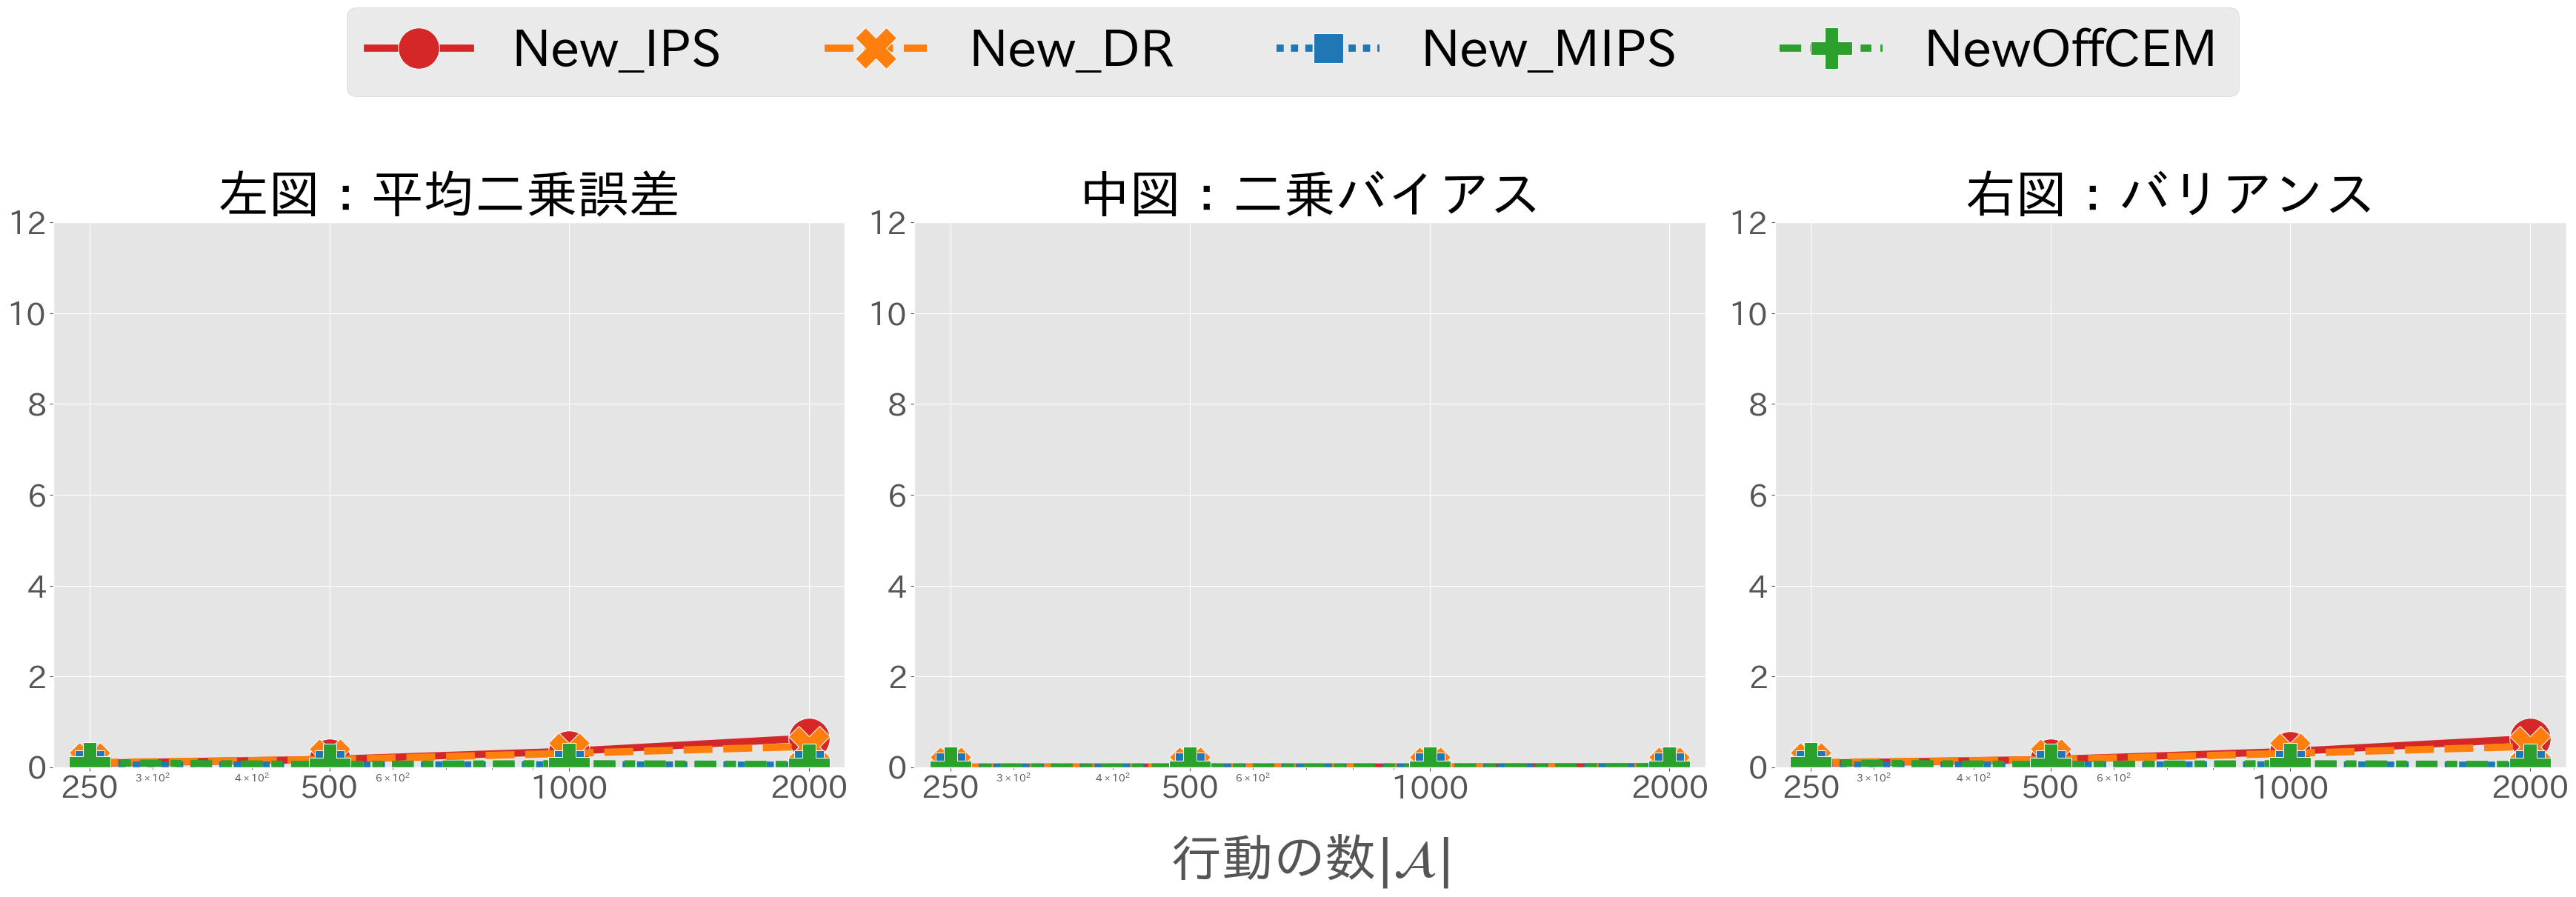

In [20]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_actions",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange", "tab:blue", "tab:green"],
        data=result_df_actions.query("est == 'Newips' or  est == 'Newdr' or est == 'Newmips' or est == 'NewOffCEM'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 3.0)
    ax.set_yticks([0, 2, 4, 6, 8, 10, 12])
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"行動の数$|\mathcal{A}|$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_actions_list)
    ax.set_xticklabels(num_actions_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["New_IPS", "New_DR", "New_MIPS", "NewOffCEM"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")
